# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler
import plotter
import utils

import matplotlib.pyplot as plt
import matplotlib.pyplot
import matplotlib.dates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# Constants

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=False, enhanced=True)


Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


# Methods


In [5]:
def add_info(dataframe: pd.DataFrame) -> pd.DataFrame:
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            dataframe.loc[dataframe[times[1]].isna(), step] = (dataframe[times[2]] - dataframe[times[0]]).dt.total_seconds()
            dataframe.loc[~dataframe[times[1]].isna(), step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
        else:
            dataframe[step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
    
    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    dataframe["complied"] = np.nan
    # Define the criteria for response times
    criteria = {
        ('A', True): 12 * 60,
        ('A', False): 25 * 60,
        ('H', True): 30 * 60,
        ('H', False): 40 * 60
    }

    for (triage, urban), group in dataframe.groupby(['triage_impression_during_call', 'urban_settlement_ssb']):
        limit = criteria.get((triage, urban))
        if limit is not None:
            dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit

    return dataframe


In [6]:
def plot_compliance_rate(dataframe: pd.DataFrame, urban: bool = True, limit_left: str = None, limit_right: str = None, degree=3):
    """Plot the compliance rate from call data filtered by urban area status with a polynomial trend line."""
    def day_of_year_to_date(day_of_year, year=2019):
        """ Convert day of year to date format 'Month Day' """
        day_of_year = int(day_of_year)
        date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
        return date.strftime('%B %d')

    # extract date from time_call_received
    dataframe["day_of_year"] = dataframe["time_call_received"].dt.day_of_year

    start_time = pd.to_datetime('07:00:00').time()
    end_time = pd.to_datetime('18:59:59').time()

    # Filter rows where time is within the defined bounds
    dataframe = dataframe[dataframe['time_call_received'].dt.time.between(start_time, end_time)]

    # filter data by urban settlement and compute compliance rate
    filtered_data = dataframe
    if urban is not None:
        filtered_data = dataframe[dataframe["urban_settlement_ssb"] == urban]
    compliance_rate = filtered_data.groupby("day_of_year")["complied"].mean().dropna() * 100

    # convert index and values to float
    x = compliance_rate.index.astype(float)
    y = compliance_rate.values.astype(float)
    mean_compliance_rate = compliance_rate.mean()

    # identify best and worst compliance days
    worst_day = compliance_rate.idxmin()
    best_day = compliance_rate.idxmax()
    average_day = (compliance_rate - mean_compliance_rate).abs().idxmin()

    best_day_date = day_of_year_to_date(best_day)
    worst_day_date = day_of_year_to_date(worst_day)
    average_day_date = day_of_year_to_date(average_day)


    print(f"Best compliance day of the year: {best_day_date} with rate {compliance_rate[best_day]:.2f}%")
    print(f"Worst compliance day of the year: {worst_day_date} with rate {compliance_rate[worst_day]:.2f}%")
    print(f"Most average compliance day of the year: {average_day_date} with rate {compliance_rate[average_day]:.2f}%")
    print(f"Mean compliance rate for the year: {mean_compliance_rate:.2f}%")

    # plot compliance rate
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, label="Compliance Rate")

    # fit and plot polynomial trend line
    z = np.polyfit(x, y, degree)
    p = np.poly1d(z)
    plt.plot(x, p(x), "-", color='grey', label=f"{degree} Degree Polynomial Fit")

    # add important days
    plt.axvline(x=best_day, color='green', label=f"Best Day ({best_day_date}) with rate {compliance_rate[best_day]:.2f}%", linestyle=':')
    plt.axvline(x=worst_day, color='red', label=f"Worst Day ({worst_day_date}) with rate {compliance_rate[worst_day]:.2f}%", linestyle=':')
    plt.axvline(x=average_day, color='blue', label=f"Average Day ({average_day_date}) with rate {compliance_rate[average_day]:.2f}%", linestyle=':')

    # set y-axis limits
    plt.ylim((0, 110))

    # set x-axis limits if specified
    if limit_left:
        plt.xlim(left=pd.Timestamp(limit_left))
    if limit_right:
        plt.xlim(right=pd.Timestamp(limit_right))

    plt.grid(True)

    # set plot title and labels
    title = f"Compliance Rate for {'Urban' if urban else 'Non-urban' if urban is not None else 'All'} Incidents During Day Shift"

    plt.title(title, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
    plt.xlabel("Day of the Year")
    plt.ylabel("Compliance Rate (%)")

    # display plot
    plt.legend()

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title + ".png"), dpi=300, bbox_inches='tight')

    plt.show()


In [7]:
def analyze_response_by_date(dataframe: pd.DataFrame, specific_date: str, year=2019):
    """
    Analyzes response data for a given MM-DD date.
    
    Parameters:
        dataframe (pd.DataFrame): The dataframe containing call data.
        specific_date (str): The specific date in 'MM-DD' format.
        year (int): The year to be considered for day of year calculation, default is 2023.
        
    Returns:
        pd.DataFrame: A DataFrame with analysis results or None if no data.
    """
    # Convert specific_date string to datetime object considering the provided year
    specific_date_dt = datetime.strptime(f"{year}-{specific_date}", "%Y-%m-%d")
    
    # Extract the day of the year from the specific_date
    day_of_year = specific_date_dt.timetuple().tm_yday
    
    # Add a 'day_of_year' column to the dataframe
    dataframe['day_of_year'] = dataframe['time_call_received'].dt.dayofyear
    
    # Filter the dataframe for the given day of the year
    date_filtered_df = dataframe[dataframe['day_of_year'] == day_of_year]
    
    if date_filtered_df.empty:
        print("No data available for the specified date.")
        return None
    
    # Group by 'urban_settlement_ssb' and 'triage_impression_during_call'
    grouped = date_filtered_df.groupby(['urban_settlement_ssb', 'triage_impression_during_call'])
    
    # Calculate mean and median response times and compliance rate
    response_stats = grouped['total_response_time'].agg(['mean', 'median']).reset_index()
    compliance_rate = grouped['complied'].mean().reset_index()
    compliance_rate.columns = ['urban_settlement_ssb', 'triage_impression_during_call', 'compliance_rate']
    
    # Merge stats and compliance rate into a single DataFrame
    result = pd.merge(response_stats, compliance_rate, on=['urban_settlement_ssb', 'triage_impression_during_call'], how='outer')
    
    # Handling NaN values in compliance_rate by filling them with a default or a note
    result['compliance_rate'] = result['compliance_rate'].apply(lambda x: f"{np.round(x * 100, 2)}%" if pd.notna(x) else "N/A")
    
    # Convert response times from seconds to minutes for better readability
    result['mean'] = (result['mean'] / 60).round(2)
    result['median'] = (result['median'] / 60).round(2)
    
    return result



In [8]:
def find_best_and_worst_compliance_days(dataframe: pd.DataFrame):
    # Ensure the time_call_received is in datetime format
    if dataframe['time_call_received'].dtype != 'datetime64[ns]':
        dataframe['time_call_received'] = pd.to_datetime(dataframe['time_call_received'])
    
    # Filter the dataframe for the year 2018
    dataframe['year'] = dataframe['time_call_received'].dt.year
    year_filtered_df = dataframe[dataframe['year'] == 2018]
    
    if year_filtered_df.empty:
        print("No data available for the year 2018.")
        return None
    
    # Extract date from time_call_received
    year_filtered_df['date'] = year_filtered_df['time_call_received'].dt.date
    
    # Group by date and calculate the mean compliance rate for each day
    daily_compliance = year_filtered_df.groupby('date')['complied'].mean()
    
    # Find the best and worst days
    best_day = daily_compliance.idxmax()
    worst_day = daily_compliance.idxmin()
    best_day_rate = daily_compliance.max()
    worst_day_rate = daily_compliance.min()
    
    # Return results in a clear format
    results = {
        'Best Day': best_day,
        'Best Day Compliance Rate': best_day_rate,
        'Worst Day': worst_day,
        'Worst Day Compliance Rate': worst_day_rate
    }
    
    return results


# Main

In [9]:
dataframe = data_loader.enhanced_incidents_df.copy(deep=True)
dataframe = add_info(dataframe)


C:\Users\sindr\AppData\Local\Temp\ipykernel_16176\1518890614.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


Best compliance day of the year: April 12 with rate 86.64%
Worst compliance day of the year: March 05 with rate 65.71%
Most average compliance day of the year: January 30 with rate 76.82%
Mean compliance rate for the year: 76.83%


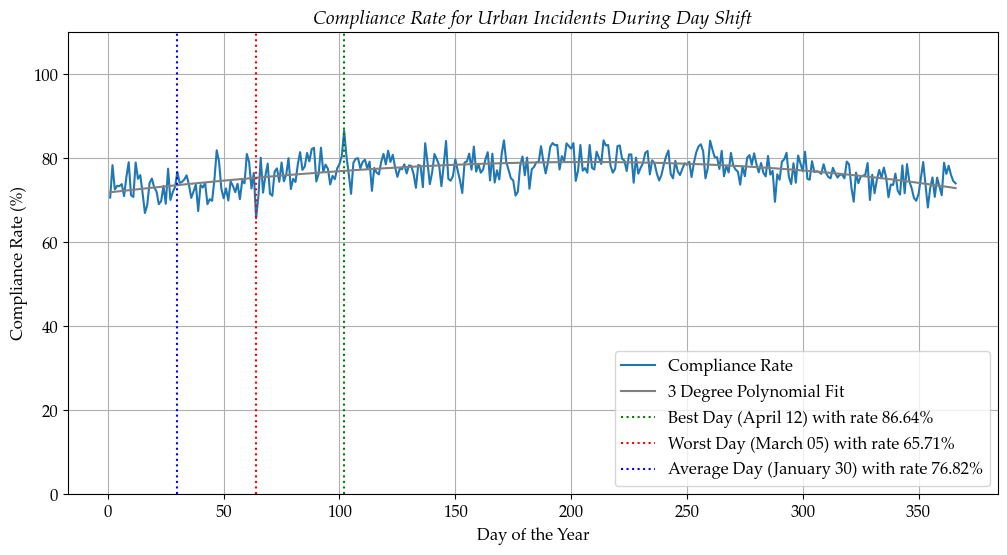

Best compliance day of the year: April 26 with rate 100.00%
Worst compliance day of the year: December 30 with rate 60.98%
Most average compliance day of the year: March 18 with rate 88.89%
Mean compliance rate for the year: 88.95%


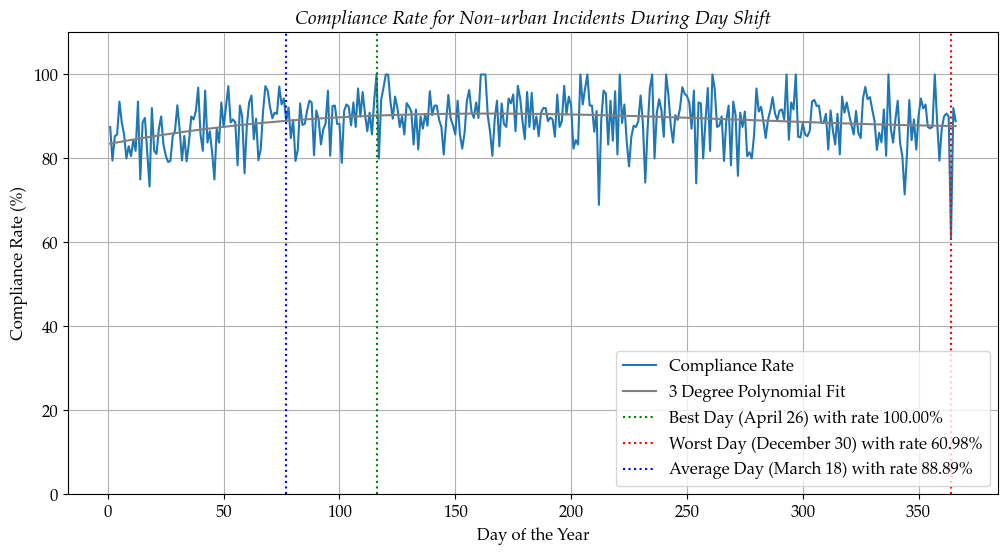

Best compliance day of the year: April 12 with rate 86.98%
Worst compliance day of the year: March 05 with rate 67.85%
Most average compliance day of the year: July 14 with rate 77.84%
Mean compliance rate for the year: 77.85%


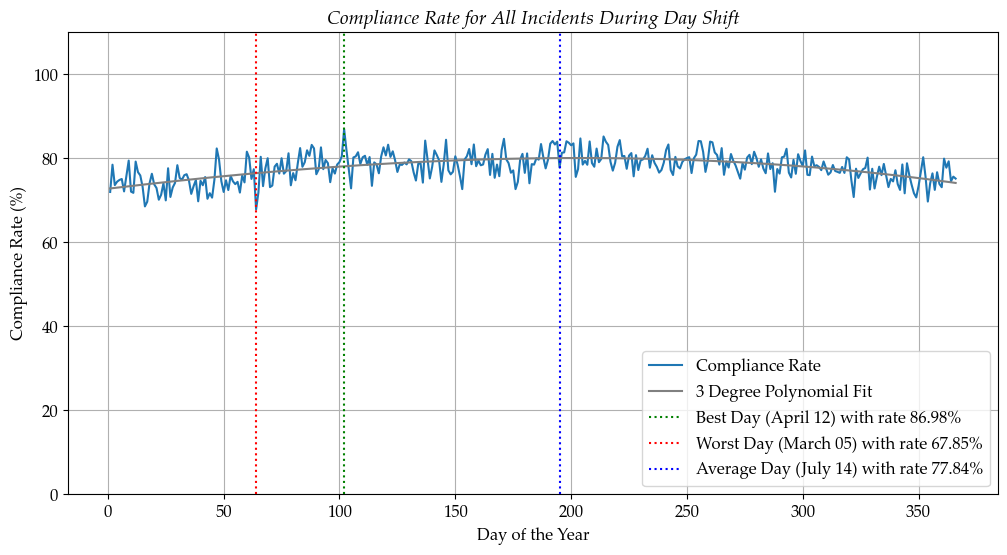

In [10]:
plot_compliance_rate(dataframe, urban=True)
plot_compliance_rate(dataframe, urban=False)
plot_compliance_rate(dataframe, urban=None)


In [11]:
analyze_response_by_date(dataframe, specific_date="01-30")


,urban_settlement_ssb,triage_impression_during_call,mean,median,compliance_rate
0,False,A,15.30,14.58,97.14%
1,False,H,27.63,24.42,83.87%
2,False,V1,44.39,39.72,N/A
3,True,A,10.47,9.50,69.15%
4,True,H,21.37,17.73,83.77%
5,True,V1,75.83,58.58,N/A
